In [1]:
import skimage.io as io

In [2]:
cell_img = io.imread("./data/cell_3ch_patch.tif").astype(float)
cell_mask = io.imread("./data/mask.tif").astype(bool)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [4]:
def line_array(color,i):
    import numpy as np
    if (color=="cyan") or (color=="c"):
        line = np.array([0/256, (i+1)/256, (i+1)/256, 1])
    elif (color=="magenta") or (color=="m"):
        line = np.array([(i+1)/256, 0/256, (i+1)/256, 1])
    elif (color=="blue") or (color=="b"):
        line = np.array([0/256, 0/256, (i+1)/256, 1])
    return(line)
def create_fluo_cm(color):
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    import numpy as np
    grays = cm.get_cmap('gray', 256)
    newcolors = grays(np.linspace(0, 1, 256))
    for i in range(1,newcolors.shape[0]):
        newcolors[i,:] = line_array(color,i)
    newcmp = ListedColormap(newcolors)
    return(newcmp)

In [184]:
cyan_cm = create_fluo_cm("c")
magenta_cm = create_fluo_cm("m")
cm_list = [magenta_cm, cyan_cm]

In [172]:
class IonChannel(object):
    def __init__(self,ion,lin,col,ide):
        self.id = ide
        self.x = int(col)
        self.y = int(lin)
        self.ion = ion
        self.state = 'closed'
    def ch_open(self):
        self.state = 'open'
    def ch_close(self):
        self.state = 'closed'

In [252]:
def create_channels(n=30,ion='K+'): 
    import skimage.measure as measure
    global cell_mask
    import numpy as np
    # get cell contour
    contours = measure.find_contours(cell_mask.astype(int),0)
    # calculate the step size necessary to divide the contours vector in 30 pieces
    step = len(contours[0])//30
    # calculate the rest that is left of the vector after dividing it in 30 pieces
    rest = len(contours[0])%30
    
    if ion=='K+':
        # takes the coordinates of each step
        coords = contours[0][::step]
        coords = coords[:-1]
    else:
        # takes the coordinates of each step, but starting at half step
        coords = contours[0][step//2::step] 
    
    ch_list = []
    coords = coords[np.random.choice(30, n, replace=False)]
    for counter,value in enumerate(coords):
        ch_list.append(IonChannel(ion,value[0],value[1],counter))
    return(ch_list)

In [274]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np

'''################ Callback functions ################'''
# Updates image from channel selection change
def update_screen(v):
    '''Function that updates images when images need to be update 
    (for example, when channel is changed)'''
    global cell_img, K_list, Na_list
    ax.clear()
    # clear images
    out.clear_output(wait=True)
    with out:
        # if channel 1 is selected (index=0)
        if channel_sel.index==0:
            # show cell image
            ax.imshow(cell_img[:,:,0],cmap='gray')
        # if channel 2 is selected (index=1)
        else:
            # show K image
            ax.imshow(cell_img[:,:,channel_sel.index],cmap=cm_list[channel_sel.index-1],vmin=0,vmax=255)  
            if adv_check.value==True:
                for ch in K_list:
                    if ch.state=='open':
                        color = 'g'
                    else:
                        color = 'r'
                    ax.plot(ch.x,ch.y,marker='d',color=color,ms=12,mew=2,mec='white')
                for ch in Na_list:
                    if ch.state=='open':
                        color = 'g'
                    else:
                        color = 'r'
                    ax.plot(ch.x,ch.y,marker='s',color=color,ms=12,mew=2,mec='white')
#         # if channel 3 is selected (index=2)
#         elif channel_sel.index==2:
#             # show Na image
#             ax.imshow(cell_img[:,:,2],cmap=green_cm,vmin=0,vmax=255)
#             if adv_check.value=True:
#                 for ch in K_list:
#                     if ch.state=='open':
#                         color = 'g'
#                     else:
#                         color = 'r'
#                     ax.plot(ch.x,ch.y,marker='d',color=color,ms=12,mew=2,mec='white')
#                 for ch in K_list:
#                     if ch.state=='open':
#                         color = 'g'
#                     else:
#                         color = 'r'
#                     ax.plot(ch.x,ch.y,marker='s',color=color,ms=12,mew=2,mec='yellow')
        
        
        
        display(fig)
        
# Updates graphics
def update_graphics(Na_o, Na_i, K_o, K_i):
    '''Function that updates graphics'''
    ax2[0].clear()
    ax2[1].clear()
    # clear graphics
    out2.clear_output(wait=True)
    with out2:
        # show cell image on axes
        time = np.linspace(0,100)
        #sources: https://www.cell.com/biophysj/pdf/S0006-3495(81)84820-5.pdf
        #        https://en.wikipedia.org/wiki/Goldman_equation
        # approximating R*T/F to 26.7 mV (at 37ºC)
        P_K = 1.33e-7 #m/s
        P_Na = 1.92e-10 #m/s
        Em = 26.7*np.log( ( (P_Na * Na_o) + (P_K * K_o) ) / ( (P_Na * Na_i) + (P_K * K_i) ) )
#         v0 = -80
        potential = Em*np.ones(time.shape)
        ax2[0].plot(time, potential)
        ax2[0].set_ylabel('Potencial de Membrana (mV)')
        ax2[0].set_xlabel('Tempo (s)')
        ax2[0].set_ylim([-210,210])
        
        print('Em = ' + str(np.around(Em,2)) + ' mV')
        Na_i_vector = Na_i*np.ones(time.shape)
        Na_o_vector = Na_o*np.ones(time.shape)
        K_i_vector = K_i*np.ones(time.shape)
        K_o_vector = K_o*np.ones(time.shape)
        ax2[1].plot(time, Na_i_vector,'cyan',label='[Na+]i')
        ax2[1].plot(time, Na_o_vector,'b',label='[Na+]o')
        ax2[1].plot(time, K_i_vector,'magenta',label='[K+]i')
        ax2[1].plot(time, K_o_vector,'purple',label='[K+]o')
        ax2[1].set_ylabel('Concentração (mM)')
        ax2[1].set_xlabel('Tempo (s)')
        ax2[1].legend(loc='upper right')
        display(fig2)
        
def on_concentration_slider(v):
    '''Function that updates images when concentration bars are changed'''
    from skimage.filters import gaussian
    import numpy as np
    global cell_img, cell_mask, Na_o, Na_i, K_o, K_i
    value = v['new']
    if value==0:
        value = 0.1
    # if changed bar is K+ i
    if v['owner'].description.startswith('[K+]i'):
        cell_img[:,:,1][cell_mask] = v['new']
        cell_img[:,:,1] = gaussian(cell_img[:,:,1],sigma=2,multichannel=False)
        channel_sel.index = 1
        K_i = value
    # if changed bar is K+ o
    elif v['owner'].description.startswith('[K+]o'):
        cell_img[:,:,1][np.invert(cell_mask)] = v['new']
        cell_img[:,:,1] = gaussian(cell_img[:,:,1],sigma=2,multichannel=False)
        channel_sel.index = 1
        K_o = value
    # if changed bar is Na+ i
    elif v['owner'].description.startswith('[Na+]i'):
        cell_img[:,:,2][cell_mask] = v['new']
        cell_img[:,:,2] = gaussian(cell_img[:,:,2],sigma=2,multichannel=False)
        channel_sel.index = 2
        Na_i = value
    # if changed bar is Na+ i
    elif v['owner'].description.startswith('[Na+]o'):
        cell_img[:,:,2][np.invert(cell_mask)] = v['new']
        cell_img[:,:,2] = gaussian(cell_img[:,:,2],sigma=2,multichannel=False)
        channel_sel.index = 2
        Na_o = value
    #Update screen
    update_screen(0)        
    update_graphics(Na_o, Na_i, K_o, K_i) 

def on_adv_check(v):
#     global Na_o, Na_i, K_o, K_i, Na_o_slider
    if v['new']==True:
        Na_ch_slider.layout.visibility='visible'
#         Na_ch_label.layout.visibility='visible'
        K_ch_slider.layout.visibility='visible'
        ch_label.layout.visibility='visible'
        Na_o_slider.value = 140
        Na_i_slider.value = 10
        K_o_slider.value = 5
        K_i_slider.value = 140
        Na_o_slider.disabled = True
        Na_i_slider.disabled = True
        K_o_slider.disabled = True
        K_i_slider.disabled = True
        channel_sel.index = 1
    else:
        Na_ch_slider.layout.visibility='hidden'
#         Na_ch_label.layout.visibility='hidden'
        K_ch_slider.layout.visibility='hidden'
        ch_label.layout.visibility='hidden'
        Na_o_slider.disabled = False
        Na_i_slider.disabled = False
        K_o_slider.disabled = False
        K_i_slider.disabled = False
    update_screen(0)
    
def on_channel_slider(v):
    global K_list, Na_list
    if v['owner'].description=='K+:':
        K_list = create_channels(n=v['new'],ion='K+')
        channel_sel.index = 1
    else:
        Na_list = create_channels(n=v['new'],ion='Na+')
        channel_sel.index = 2
    update_screen(0)
        
'''################ Widgets construction ################'''
    
# Widget of radiobox for channel selection
channel_sel = widgets.RadioButtons(
    options=['tela célula', 'tela potássio [K+]', 'tela sódio [Na+]'],
    description='',
    disabled=False 
)

# widget of output images
out = widgets.Output(layout={'border': '1px solid black'})
# widget of output graphic
out2 = widgets.Output(layout={'border': '1px solid black'})
# widget of Na+ o slider
Na_o_slider = widgets.IntSlider(
    value=140,
    min=0,
    max=200,
    step=1,
    description='[Na+]o (mM):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
# widget of Na+ i slider
Na_i_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=200,
    step=1,
    description='[Na+]i (mM):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
# widget of K+ o slider
K_o_slider = widgets.IntSlider(
    value=5,
    min=0,
    max=200,
    step=1,
    description='[K+]o (mM):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
# widget of K+ o slider
K_i_slider = widgets.IntSlider(
    value=140,
    min=0,
    max=200,
    step=1,
    description='[K+]i (mM):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

adv_check = widgets.Checkbox(
    value=False,
    description='Modo Avançado',
    disabled=False,
    indent=False
)
# Na_ch_label = widgets.Label(
#     value="Núm. canais de Na+:",
#     layout=widgets.Layout(visibility='hidden')
# )
Na_ch_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=30,
    step=1,
    description='Na+:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(visibility='hidden')
)
ch_label = widgets.Label(
    value="Núm. canais de",
    layout=widgets.Layout(visibility='hidden')
)
K_ch_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=30,
    step=1,
    description='K+:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(visibility='hidden',align_self='flex-start')
)
K_list = []
Na_list = []
Na_o = Na_o_slider.value
Na_i = Na_i_slider.value
K_o = K_o_slider.value
K_i = K_i_slider.value

# Block of widgets containing Na+ sliders
vbox_conc_Na = widgets.VBox([Na_o_slider,Na_i_slider], align_self='stretch',justify_content='center')
# Block of widgets containing K+ sliders
vbox_conc_K = widgets.VBox([K_o_slider,K_i_slider], align_self='stretch',justify_content='center')
# Block of widgets containing num K+ channel slider
hbox_num_ch = widgets.HBox([ch_label,K_ch_slider,Na_ch_slider], align_self='stretch',justify_content='center')
# # Block of widgets containing num Na+ channel slider
# hbox_num_ch_Na = widgets.HBox([Na_ch_label,Na_ch_slider], align_self='stretch',justify_content='center')
# # Block of widgets containing channel sliders
# vbox_num_ch = widgets.HBox([hbox_num_ch_K,hbox_num_ch_Na], align_self='stretch',justify_content='center')
# Block of widgets containing all concentration sliders
hbox_ions = widgets.HBox([vbox_conc_K,vbox_conc_Na,adv_check], align_self='stretch',justify_content='center',align_content='center')
# Block of widgets containing channel selection and output images
vbox_fig = widgets.VBox([channel_sel,out,hbox_ions,hbox_num_ch,out2], align_self='stretch',justify_content='center')
# Show cell image on first time
with out:
    # create figure and axes
    fig, ax = plt.subplots(figsize=(15,10))
    # show cell image on axes
    ax.imshow(cell_img[:,:,0],cmap='gray')
    # draw changes
    plt.show(fig)

# Show graphics on first time
with out2:
    # create figure and axes
    fig2, ax2 = plt.subplots(1,2,figsize=(15,5))
    # show cell image on axes
    time = np.linspace(0,100)
    P_K = 1.33e-7 #m/s
    P_Na = 1.92e-10 #m/s
    Em = 26.7*np.log( ( (P_Na * Na_o) + (P_K * K_o) ) / ( (P_Na * Na_i) + (P_K * K_i) ) )
    potential = Em*np.ones(time.shape)
    ax2[0].plot(time, potential)
    ax2[0].set_ylabel('Potencial de Membrana (mV)')
    ax2[0].set_xlabel('Tempo (s)')
    ax2[0].set_ylim([-210,210])
    Na_i_vector = Na_i*np.ones(time.shape)
    Na_o_vector = Na_o*np.ones(time.shape)
    K_i_vector = K_i*np.ones(time.shape)
    K_o_vector = K_o*np.ones(time.shape)
    ax2[1].plot(time, Na_i_vector,'cyan',label='[Na+]i')
    ax2[1].plot(time, Na_o_vector,'b',label='[Na+]o')
    ax2[1].plot(time, K_i_vector,'magenta',label='[K+]i')
    ax2[1].plot(time, K_o_vector,'purple',label='[K+]o')
    ax2[1].set_ylabel('Concentração (mM)')
    ax2[1].set_xlabel('Tempo (s)')
    ax2[1].legend(loc='upper right')
    # draw changes
    plt.show(fig2)

# Link changes in Radiobox widget (channel selection) to screen update function
channel_sel.observe(update_screen,names='value')
# Link changes in slider widgets (ion concentrations) to concentration function
K_i_slider.observe(on_concentration_slider, names='value')
K_o_slider.observe(on_concentration_slider, names='value')
Na_i_slider.observe(on_concentration_slider, names='value')
Na_o_slider.observe(on_concentration_slider, names='value')
adv_check.observe(on_adv_check, names='value')
K_ch_slider.observe(on_channel_slider, names='value')
Na_ch_slider.observe(on_channel_slider, names='value')

# Display main Block of widgets
vbox_fig

In [268]:
Em

-87.91461287819668

In [265]:
np.log(0)

C:\Users\Marcelo_Researcher\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

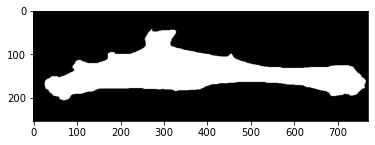

In [12]:
plt.imshow(cell_mask,cmap='gray')

In [15]:
import skimage.measure as measure
contours = measure.find_contours(cell_mask.astype(int),0)

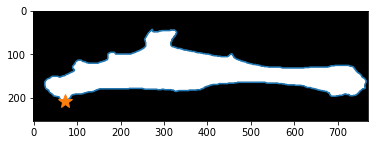

In [20]:
plt.imshow(cell_mask,cmap='gray')
plt.plot(contours[0][:,1],contours[0][:,0])
plt.plot(contours[0][0,1],contours[0][0,0],'*',ms=15)

In [32]:
div = len(contours[0])//30

In [187]:
class IonChannel(object):
    def __init__(self,ion,lin,col,ide):
        self.id = ide
        self.x = int(col)
        self.y = int(lin)
        self.ion = ion
        self.state = 'closed'
    def ch_open(self):
        self.state = 'open'
    def ch_close(self):
        self.state = 'closed'

In [245]:
def create_channels(n=30,ion='K+'): 
    import skimage.measure as measure
    global cell_mask
    import numpy as np
    # get cell contour
    contours = measure.find_contours(cell_mask.astype(int),0)
    # calculate the step size necessary to divide the contours vector in 30 pieces
    step = len(contours[0])//30
    # calculate the rest that is left of the vector after dividing it in 30 pieces
    rest = len(contours[0])%30
    
    if ion=='K+':
        # takes the coordinates of each step
        coords = contours[0][::step]
        coords = coords[:-1]
    else:
        # takes the coordinates of each step, but starting at half step
        coords = contours[0][step//2::step] 
    
    ch_list = []
    coords = coords[np.random.choice(30, n, replace=False)]
    for counter,value in enumerate(coords):
        print('counter=',counter)
        ch_list.append(IonChannel(ion,value[0],value[1],counter))
    return(ch_list)

In [238]:
a = np.random.choice(30, nn, replace=False)
b = np.random.choice(10, 5, replace=False)

In [244]:
np.random.choice(3, 40)

array([2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0,
       2, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2])

In [240]:
print(a)
print(b)
print(a[b])

[23  1 22  7 27 28 15  6  4 29  8 13 14 18 11 25]
[0 1 6 2 7]
[23  1 15 22  6]


In [249]:
nn=7
ch_list = create_channels(n=nn,ion='Na+')
ch_list2 = create_channels(n=nn,ion='K+')

counter= 0
counter= 1
counter= 2
counter= 3
counter= 4
counter= 5
counter= 6
counter= 0
counter= 1
counter= 2
counter= 3
counter= 4
counter= 5
counter= 6


In [195]:
len(ch_list)

8

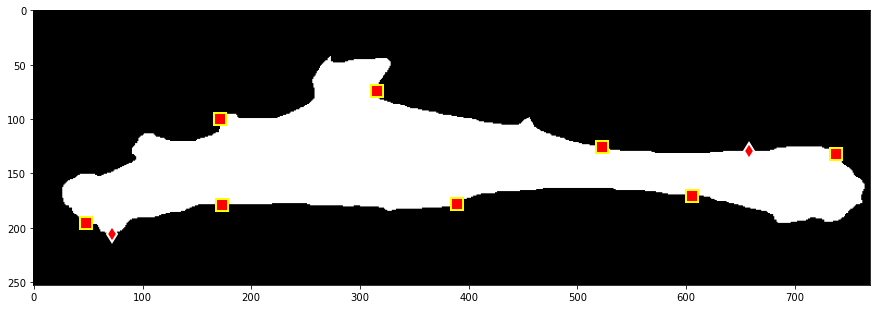

In [196]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(cell_mask,cmap='gray')
# ax.plot(contours[0][:,1],contours[0][:,0])
for ch in ch_list:
    if ch.ion=='K+':
        marker = 'd'
        mec = 'white'
    else:
        marker = 's'
        mec = 'yellow'
    if ch.state=='open':
        color = 'g'
    else:
        color = 'r'
    ax.plot(ch.x,ch.y,marker=marker,color=color,ms=12,mew=2,mec=mec)
    
for ch in ch_list2:
    if ch.ion=='K+':
        marker = 'd'
        mec = 'white'
    else:
        marker = 's'
        mec = 'yellow'
    if ch.state=='open':
        color = 'g'
    else:
        color = 'r'
    ax.plot(ch.x,ch.y,marker=marker,color=color,ms=12,mew=2,mec=mec)

In [170]:
ch_list2[2].ch_open()